## Euclidian spaces

### Importing libraries

In [3]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("science")
from scipy.optimize import linprog
import seaborn as sns
from matplotlib.animation import FuncAnimation
import warnings

### Optimal transport problem

<font color="blue">
$$
\begin{array}{c} \text{min}\\Z \in \textbf{N}^{N\text{x}N}\end{array}
\left\{ \sum_{i=1}^{N}\sum_{j=1}^{N} Z_{i,j}C_{i,j} : Z_{i,j} \geq 0 \right\}
$$
</font>

given two distributions $X$ and $Y$ with $\sum_{i}X_{i}=\sum_{j}Y_{j}$ and a cost matrix $C_{ij} = d(x_i, y_j)$.

### Generating a problem

In [4]:
# Number of points (must be even)
n = 30

In [5]:
# Generate n points in a circle of radius r and center (a, b)
def generate_round(n, a = 0., b = 0., r = 1.0, m = 20, p = 0.8, z_low = 1):
    # Sample theta in [0, 2*pi]
    theta = 2 * math.pi * np.random.rand(n)
    x = a + r * np.sin(theta)
    y = b + r * np.cos(theta)
    # Generate the weights from a binomial distribution
    z = np.maximum(np.repeat(z_low, n), np.random.binomial(m, p, n))
    return x,y,z

In [6]:
mu_x, mu_y, mu_z = generate_round(n)

In [7]:
max_z = mu_z.max()

In [8]:
# Generate n points inside a circle of radius r and center (a,b)
def generate_circle(n, a = 2.5, b = 0., r = 1.0, m = 20, p = 0.6, z_low = 1):
    x = []
    y = []
    obj = 0
    while obj < n:
        rand_x = (a - r) + 2 * r * np.random.rand()
        rand_y = (b - r) + 2 * r * np.random.rand()
        if (rand_x - a)**2 + (rand_y - b)**2 <= r**2 :
            x.append(rand_x)
            y.append(rand_y)
            obj+=1
    # Generate the weights from a poisson distribution
    z = 4 * np.maximum(np.repeat(z_low, n), np.random.poisson(2, n))
    return x,y,z

In [9]:
nu_x, nu_y, nu_z = generate_circle(n)

In [10]:
print(f"Sum nu_z = {nu_z.sum()} and Sum mu_z = {mu_z.sum()}")

Sum nu_z = 220 and Sum mu_z = 468


In [11]:
while nu_z.sum() != mu_z.sum():
    for i in range(n):
        if (nu_z.sum() < mu_z.sum()):
            nu_z[i] += 1
        elif (nu_z.sum() > mu_z.sum()):
            mu_z[i] += 1
        else:
            break

In [12]:
# Check that sum of 
print(mu_z.sum() == nu_z.sum())

True


### Visualization

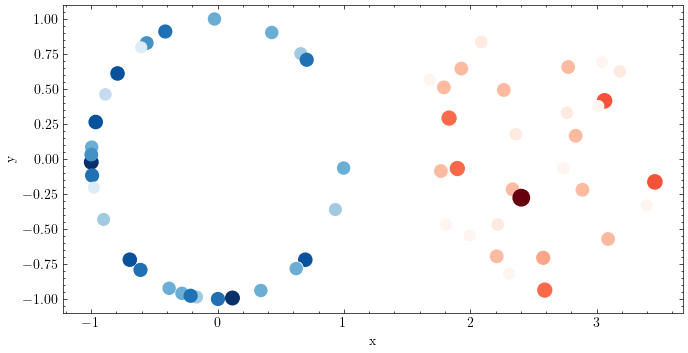

In [14]:
fig = plt.figure(figsize=(8, 4))
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(mu_x, mu_y, s = 5 * mu_z, c = mu_z / max_z, cmap = mpl.colormaps["Blues"])
plt.scatter(nu_x, nu_y, s = 5 * nu_z, c = nu_z / max_z, cmap = mpl.colormaps["Reds"])
plt.show()

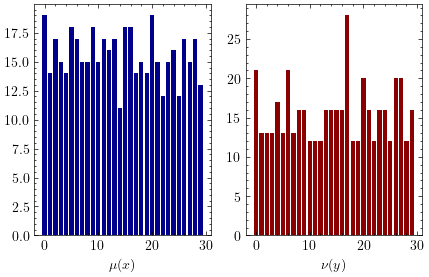

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (5, 3));
axes[0].bar(range(mu_z.size), mu_z, color = "darkblue")
axes[0].set_xlabel(r"$\mu(x)$")
axes[1].bar(range(n), nu_z, color = "darkred", label = "x")
axes[1].set_xlabel(r"$\nu(y)$")
plt.show()

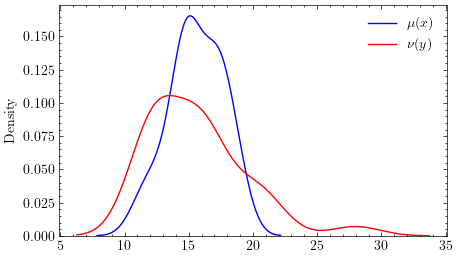

In [16]:
fig = plt.figure(figsize=(5, 3))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.kdeplot(mu_z, color = "blue", label = r"$\mu(x)$")
    sns.kdeplot(nu_z, color = "red", label = r"$\nu(y)$")
    plt.legend()
    plt.show()

### Distance matrix

In [17]:
C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        C[i, j] = np.sqrt((mu_x[i] - nu_x[j])**2 + (mu_y[i] - nu_y[j])**2)

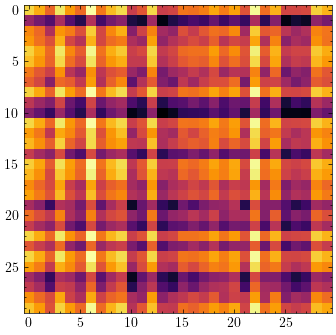

In [19]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(C,cmap = mpl.colormaps["inferno"])
plt.show()

### Solve the OT problem

Let's solve the integer linear program (ILP) 

<font color="blue">
$$
\begin{align}
\text{min} \big\{ <c, z> : p \geq 0, Az = b\big\}
\end{align}
$$
</font>

where 
- c is the vectorized distance matrix C
- z is the vectorized matrix Z
- $A = \left[\begin{array}{c}I_{N} \otimes 1_{1\text{x}N}\\
1_{1\text{x}N} \otimes I_{N}\\
\end{array}\right]$
- and $b=\left[\begin{array}{c}x\\ y \end{array}\right]$

In [20]:
Ax = np.kron(np.identity(n), np.ones(n))
Ay = np.kron(np.ones(n), np.identity(n))
A = np.concatenate((Ax, Ay), 0)
b = np.concatenate((mu_z, nu_z))
c = C.reshape(n * n)

In [21]:
res = linprog(c, A_eq = A, b_eq = b, method = 'highs')

### Visual checking

In [23]:
z = res.x
Z = z.reshape((n, n))

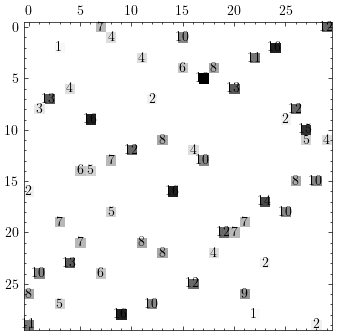

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(Z, cmap = mpl.colormaps["Greys"])
for i in range(n):
    for j in range(n):
        value = int(Z[i, j])
        if value > 0:
            plt.text(j,i, int(Z[i,j]), horizontalalignment = 'center',
                verticalalignment = 'center', weight = 'bold', color = "black")
plt.show()

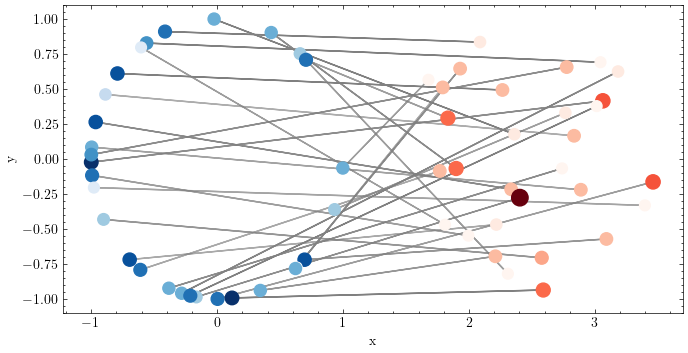

In [25]:
fig = plt.figure(figsize=(8, 4))
plt.xlabel("x")
plt.ylabel("y")
for i in range(n):
    for j in range(n):
        if Z[i, j] > 0. :
            delta_x = nu_x[i] - mu_x[i]
            delta_y = nu_y[i] - mu_y[i]
            plt.arrow(mu_x[i], mu_y[i], delta_x, delta_y, head_width=0.01, color = "grey",
                      alpha = Z[i, j] / Z[:, j].sum())
plt.scatter(mu_x, mu_y, s = 5 * mu_z, c = mu_z / max_z, cmap = mpl.colormaps["Blues"])
plt.scatter(nu_x, nu_y, s = 5 * nu_z, c = nu_z / max_z, cmap = mpl.colormaps["Reds"])
plt.show()

In [26]:
def save_animation(filename):
    # Animated plot
    xlims = [-1.1, 3.6]
    ylims = [-1.1, 1.1]
    frames = 20
    fig, ax = plt.subplots(figsize=(8, 4))
    def update(k):
        ax.clear()
        ax.set_title("Optimal transport in euclidian space")
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.scatter(mu_x, mu_y, s = 5 * mu_z, c = mu_z / max_z, cmap = mpl.colormaps["Blues"])
        ax.scatter(nu_x, nu_y, s = 5 * nu_z, c = nu_z / max_z, cmap = mpl.colormaps["Reds"])
        if k + 1 < frames :
            for i in range(n):
                for j in range(n):
                    if Z[i, j] > 0. :
                        delta_x = (nu_x[i] - mu_x[i])/ frames
                        delta_y = (nu_y[i] - mu_y[i]) / frames
                        ax.scatter(mu_x[i] + (k + 1) * delta_x, mu_y[i] + (k + 1) * delta_y,
                               s = 5 * Z[i, j], color = "grey")
    ani = FuncAnimation(fig, update, interval = 500, frames = frames)
    ani.save(filename)

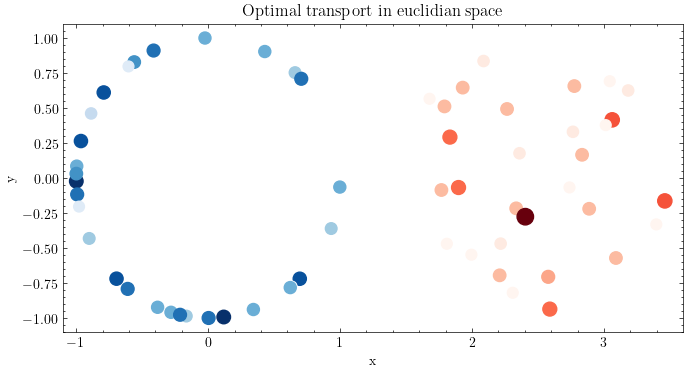

In [27]:
save_animation("../_figures/euclidian_space.gif")